In [1]:
import pandas as pd 

fonts_df = pd.read_csv('./fonts.csv')
print(f'[?] We have {fonts_df.shape[0]} fonts in our dataset')

fonts_df.head()

[?] We have 1924 fonts in our dataset


,name,url
0,mayonice,https://dl.dafont.com/dl/?f=mayonice
1,lemon_tuesday,https://dl.dafont.com/dl/?f=lemon_tuesday
2,cheese_orange,https://dl.dafont.com/dl/?f=cheese_orange
3,whitenice,https://dl.dafont.com/dl/?f=whitenice
4,bakso_daging,https://dl.dafont.com/dl/?f=bakso_daging


In [2]:
chars = 'abcdefghijklmnopqrstuvwxyz'.upper()
chars_dict = { c: chars.index(c) for c in chars }

In [4]:
import json 

with open('./blacklisted.json') as file:
    blacklisted = json.load(file)

blacklisted = [ 
    s.replace('public', 'fonts').replace('.png', '.ttf').replace('font_outputs/', '') for s in blacklisted 
]

blacklisted = [b[:-4] for b in blacklisted]

print(len(blacklisted))

617


In [7]:
import os, random

def get_random_font(mode='train', verbose=False, return_allowed=False):
    allowed_fonts = [f'./fonts/{f}' for f in os.listdir('./fonts') if 'bold' not in f.lower()]
    allowed_fonts = [f for f in allowed_fonts if f not in blacklisted]

    train_split = 0.8
    test_split = 0.1

    if mode == 'train':
        allowed_fonts = allowed_fonts[:int(len(allowed_fonts) * train_split)]

    elif mode == 'test':
        allowed_fonts = allowed_fonts[int(len(allowed_fonts) * train_split):int(len(allowed_fonts) * (train_split + test_split))]

    elif mode == 'val':
        allowed_fonts = allowed_fonts[int(len(allowed_fonts) * (train_split + test_split)):]

    if verbose:
        print(f'[?] We have {len(allowed_fonts)} fonts for {mode} split')

    font = random.choice(allowed_fonts)

    if return_allowed:
        return allowed_fonts
    return font

In [8]:
get_random_font('train', True)
get_random_font('test', True)
get_random_font('val', True)
None

[?] We have 1404 fonts for train split
[?] We have 176 fonts for test split
[?] We have 176 fonts for val split


In [9]:
import matplotlib.pyplot as plt 
from PIL import Image, ImageDraw, ImageFont

import cv2, random, os
import numpy as np

def write_char(char: str, font_path: str):    
    font_size = 55 
    font = ImageFont.truetype(font_path, font_size)

    img = Image.new('RGB', (128, 128), (255, 255, 255))
    draw = ImageDraw.Draw(img)

    # Get exact bounding box
    bbox = draw.textbbox((0, 0), char, font=font)
    text_width = bbox[2] - bbox[0]
    text_height = bbox[3] - bbox[1]

    # Compute proper centering
    x = (img.width - text_width) / 2 - bbox[0]  # Center X
    y = (img.height - text_height) / 2 - bbox[1]  # Center Y

    # Draw text properly centered
    draw.text((x, y), char, font=font, fill=(0, 0, 0))
    return img


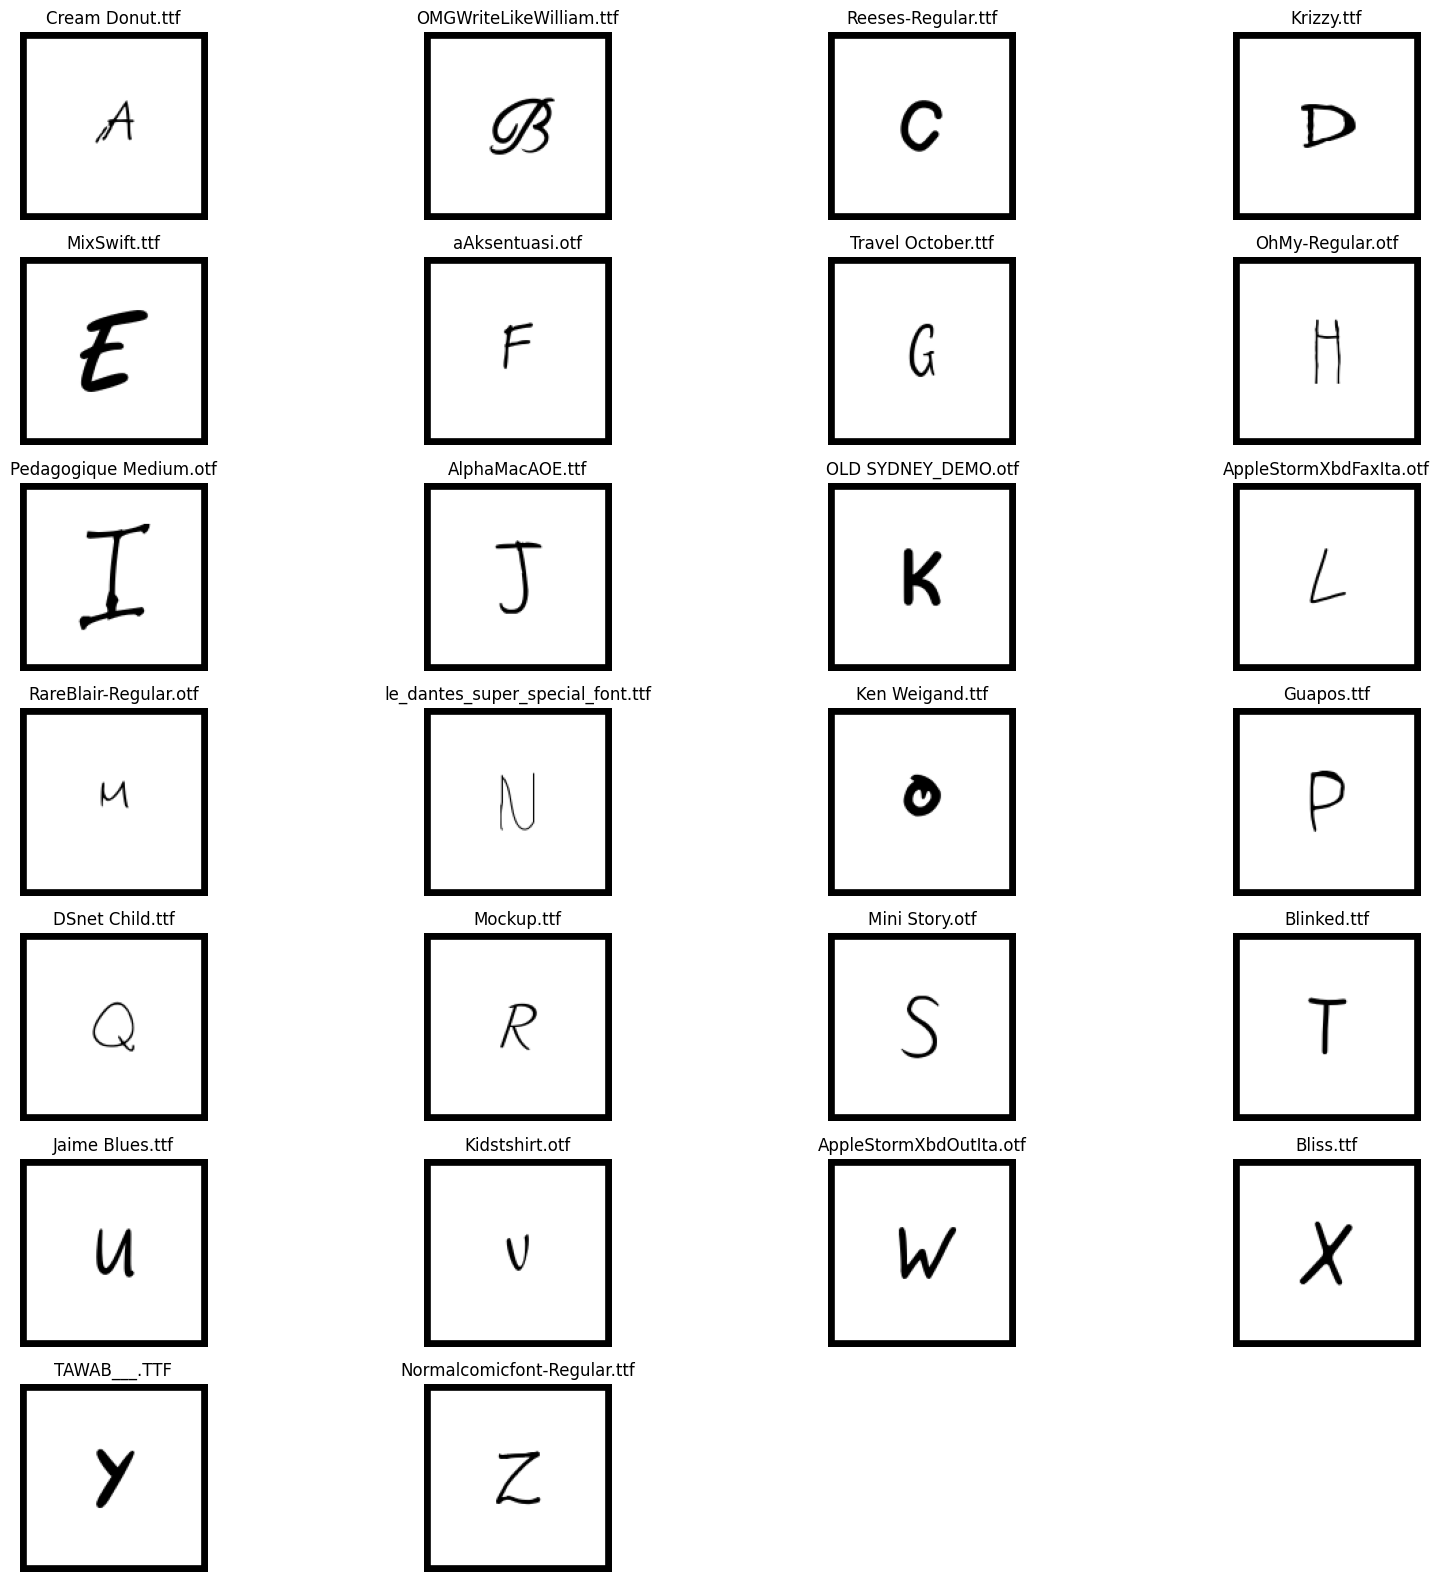

In [10]:
from PIL import ImageOps

def plot_all_alphabets():
    # plot alphabets from a to z (26) in a single plt figure
    # each alphabet belonging to random font 

    fig, axs = plt.subplots(7, 4, figsize=(20, 20))
    axs = axs.ravel()

    for i, char in enumerate(chars):
        font_path = random.choice(os.listdir('./fonts/'))
        img = write_char(char, get_random_font())
        
        # Add border to the image
        img_with_border = ImageOps.expand(img, border=5, fill='black')

        axs[i].imshow(img_with_border)
        axs[i].axis('off')
        axs[i].set_title(f'{font_path}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.show()

plot_all_alphabets()

[?] Font: ./fonts/Monday Ramen.ttf
[?] Character: J


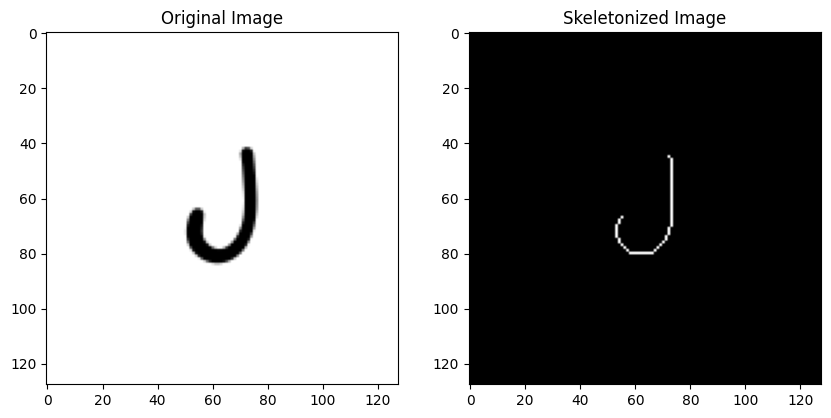

In [11]:
from skimage.morphology import skeletonize as sks 

def skeletonize_image(img):
    img = cv2.bitwise_not(img)
    img = img / 255

    skel = sks(img)
    skel = skel.astype(np.uint8)

    return skel


params = {
    'char': random.choice(chars),
    'font_path': get_random_font()
}

print(f'[?] Font: {params["font_path"]}')
print(f'[?] Character: {params["char"]}')

test_img = write_char(**params)

img = np.array(test_img.convert('L'))
skel = skeletonize_image(img)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)

plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(skel, cmap='gray')

plt.title('Skeletonized Image')
plt.show()

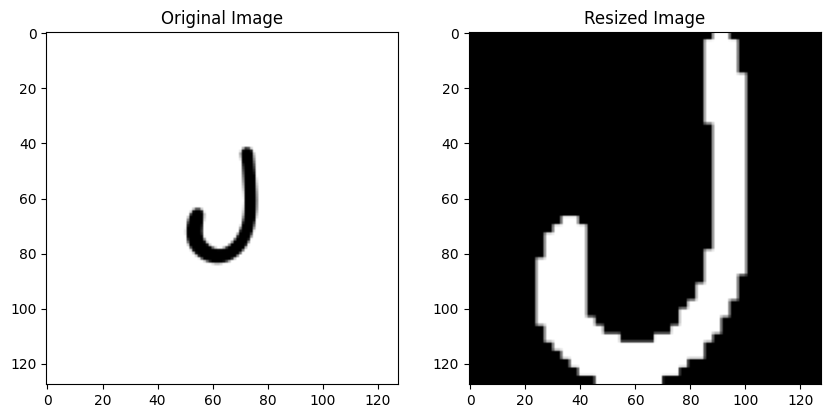

In [12]:
def max_zoom_and_resize(img, size=128):

    _, img = cv2.threshold(img, 128, 255, cv2.THRESH_BINARY_INV)
    non_zero = cv2.findNonZero(img)

    x, y, w, h = cv2.boundingRect(non_zero)
    cropped = img[y:y+h, x:x+w]

    max_side = max(w, h)
    square_canvas = np.zeros((max_side, max_side), dtype=np.uint8)

    x_offset = (max_side - w) // 2
    y_offset = (max_side - h) // 2

    square_canvas[y_offset:y_offset+h, x_offset:x_offset+w] = cropped
    resized = cv2.resize(square_canvas, (size, size), interpolation=cv2.INTER_AREA)

    return resized

resized = max_zoom_and_resize(img)


plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)

plt.imshow(img, cmap='gray')
plt.title('Original Image')

plt.subplot(1, 2, 2)
plt.imshow(resized, cmap='gray')

plt.title('Resized Image')
plt.show()

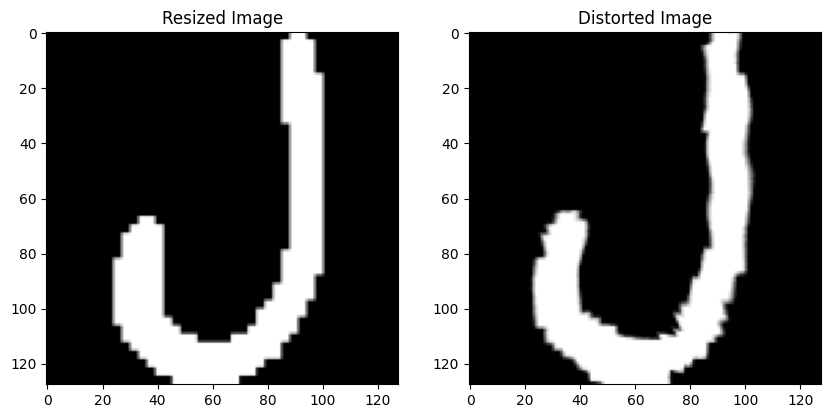

In [13]:
def elastic_distortion(image, alpha_range=(16, 32), sigma_range=(4, 8)):
    """Apply elastic distortion to an image with randomized strength."""
    image = np.array(image)

    # Randomize distortion parameters per image
    alpha = np.random.uniform(*alpha_range) * 2.1  # Increased alpha
    sigma = np.random.uniform(*sigma_range) * 0.99  # Increased sigma

    # Create displacement fields
    random_state = np.random.RandomState(None)
    dx = cv2.GaussianBlur((random_state.rand(*image.shape[:2]) * 2 - 1), (25, 25), sigma) * alpha
    dy = cv2.GaussianBlur((random_state.rand(*image.shape[:2]) * 2 - 1), (25, 25), sigma) * alpha

    # Create meshgrid for remapping
    x, y = np.meshgrid(np.arange(image.shape[1]), np.arange(image.shape[0]))
    map_x = (x + dx).astype(np.float32)
    map_y = (y + dy).astype(np.float32)

    # Apply distortion
    distorted = cv2.remap(image, map_x, map_y, interpolation=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT)
    return Image.fromarray(distorted)


distorted = elastic_distortion(resized)

plt.figure(figsize=(10, 10))
plt.subplot(1, 2, 1)

plt.imshow(resized, cmap='gray')
plt.title('Resized Image')

plt.subplot(1, 2, 2)
plt.imshow(distorted, cmap='gray')

plt.title('Distorted Image')
plt.show()

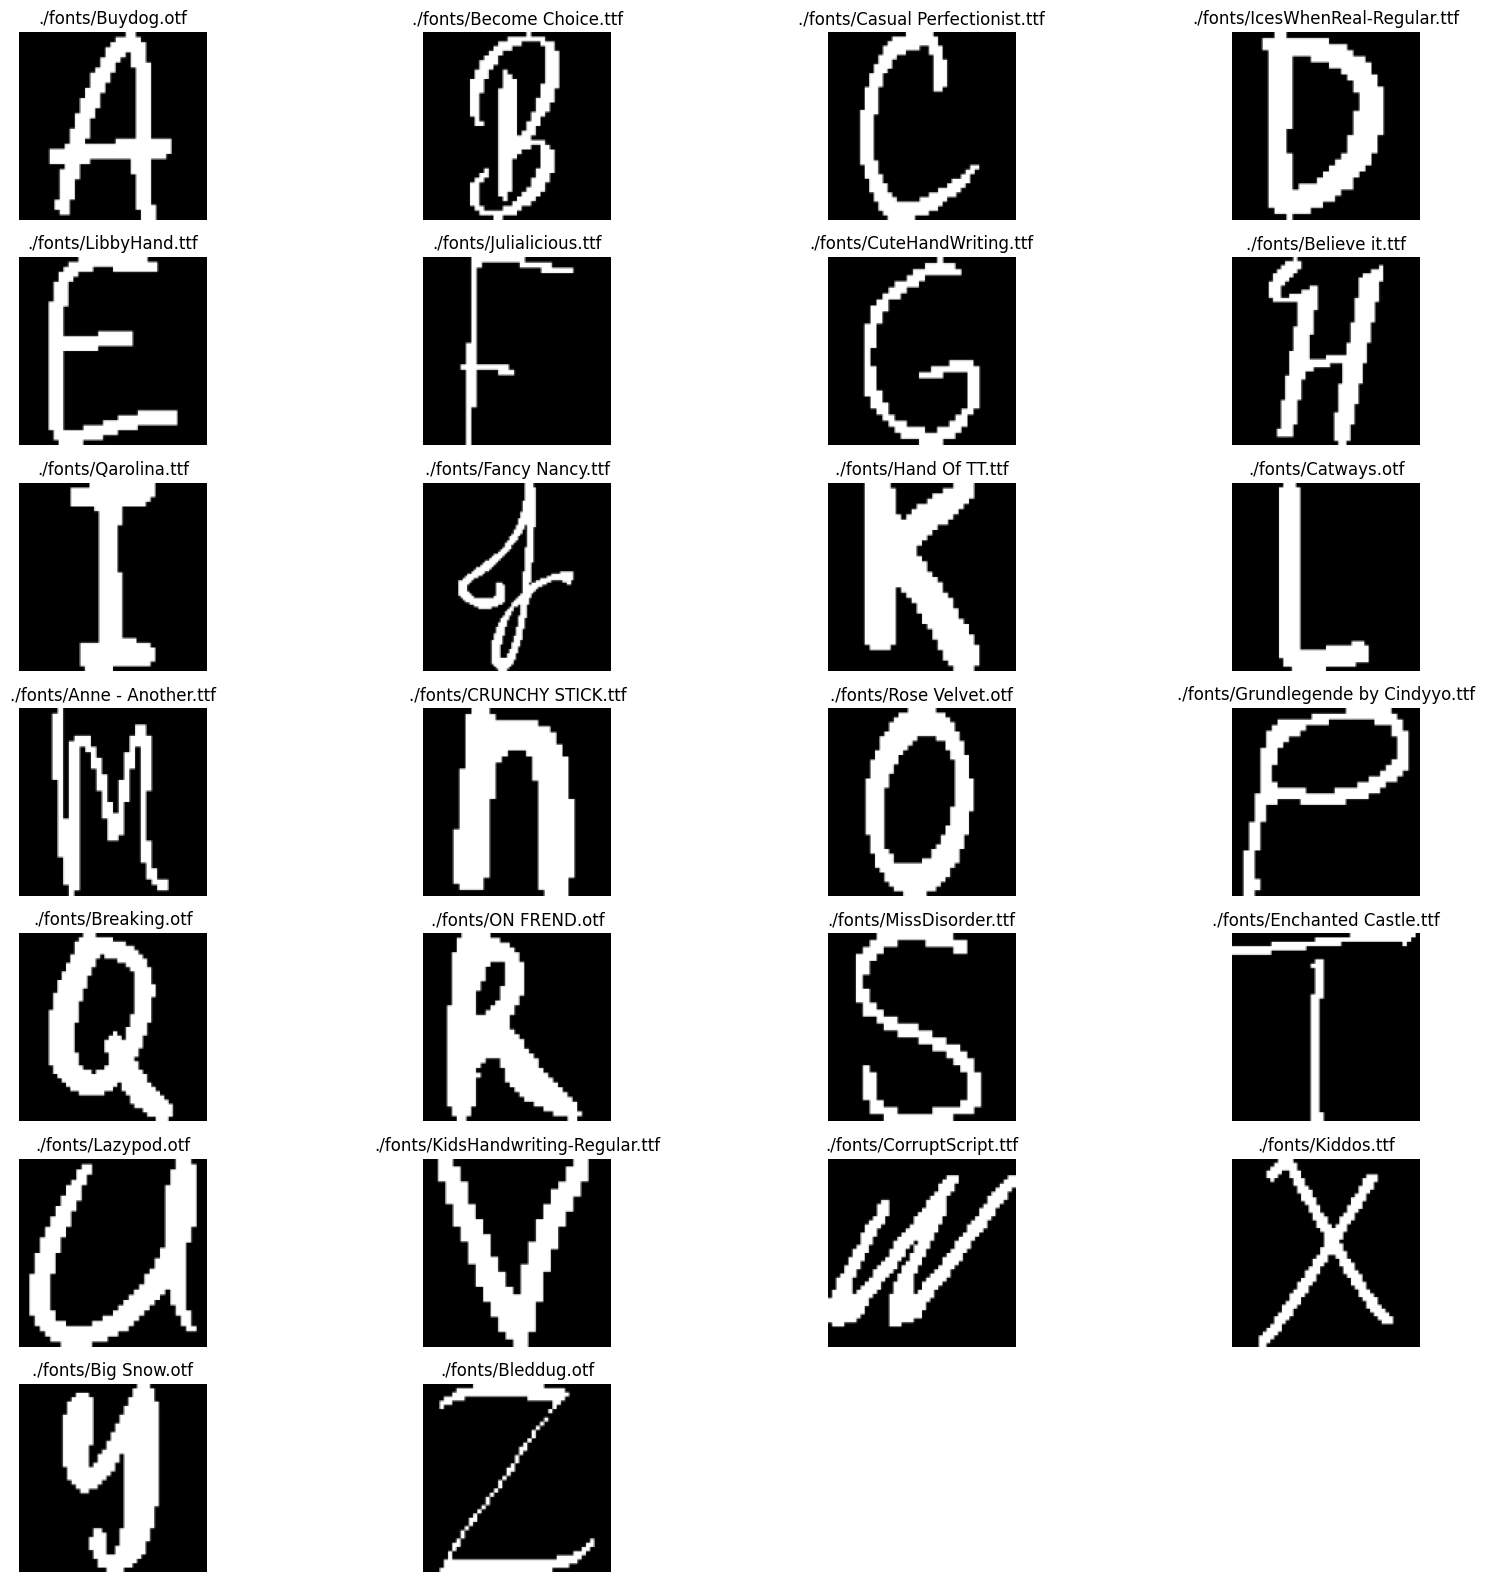

In [14]:
def plot_random_chars():
    fig, axs = plt.subplots(7, 4, figsize=(20, 20))
    axs = axs.ravel()

    for i, char in enumerate(chars):

        font_path = get_random_font()
        img = write_char(char, font_path)
        
        # Skeletonization
        img = np.array(img.convert('L'))
        # img = skeletonize_image(img)

        # Resize
        img = max_zoom_and_resize(img)

        # Elastic distortion
        # img = elastic_distortion(img)

        axs[i].imshow(img, cmap='gray')
        axs[i].axis('off')

        axs[i].set_title(f'{font_path}')

    # Hide any remaining empty subplots
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    plt.show()

plot_random_chars()

In [15]:
(len(os.listdir('./fonts')) - 61 - 617) * (3 + 7) * (26) 

456560

In [17]:
def generate_dataset(split='train'):
    i = 0
    split_fonts = get_random_font(mode=split, return_allowed=True)

    print(f'[?] Generating dataset for {split} split')
    print(f'[?] We have {len(split_fonts)} fonts for {split} split')

    for char in chars:
        for file in split_fonts:
            try:
                for _ in range(1, 6):
                    img = write_char(char, file)

                    img = np.array(img.convert('L'))
                    img = max_zoom_and_resize(img)

                    if i > 2:
                        img = elastic_distortion(img)
                    else:
                        img = Image.fromarray(img)
                    
                    if not os.path.exists(f'./dataset/{split}/{char}'):
                        os.makedirs(f'./dataset/{split}/{char}')

                    img.save(f'./dataset/{split}/{char}/{i}.png')
                    i += 1

            except Exception as e:
                print(f'  [!] Error during {file}, skipped.', e)
                # break
                continue

        print(f'[>] Saved {char}')

In [18]:
generate_dataset('test')

[?] Generating dataset for test split
[?] We have 176 fonts for test split
[>] Saved A
[>] Saved B
[>] Saved C
[>] Saved D
[>] Saved E
[>] Saved F
[>] Saved G
[>] Saved H
[>] Saved I
[>] Saved J
[>] Saved K
[>] Saved L
[>] Saved M
[>] Saved N
[>] Saved O
[>] Saved P
[>] Saved Q
[>] Saved R
[>] Saved S
[>] Saved T
[>] Saved U
[>] Saved V
[>] Saved W
[>] Saved X
[>] Saved Y
[>] Saved Z


In [19]:
generate_dataset('val') 

[?] Generating dataset for val split
[?] We have 176 fonts for val split
  [!] Error during ./fonts/varsity_demo.otf, skipped. OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[>] Saved A
  [!] Error during ./fonts/varsity_demo.otf, skipped. OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[>] Saved B
  [!] Error during ./fonts/varsity_demo.otf, skipped. OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[>] Saved C
  [!] Error during ./fonts/varsity_demo.otf, skipped. OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[>] Saved D
  [!] E

In [20]:
generate_dataset('train')

[?] Generating dataset for train split
[?] We have 1404 fonts for train split
[>] Saved A
[>] Saved B
[>] Saved C
[>] Saved D
  [!] Error during ./fonts/InconsistentPrint-Regular.ttf, skipped. OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[>] Saved E
[>] Saved F
[>] Saved G
[>] Saved H
[>] Saved I
[>] Saved J
[>] Saved K
[>] Saved L
[>] Saved M
[>] Saved N
[>] Saved O
[>] Saved P
[>] Saved Q
[>] Saved R
[>] Saved S
[>] Saved T
  [!] Error during ./fonts/kidswriting.ttf, skipped. OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[>] Saved U
  [!] Error during ./fonts/kidswriting.ttf, skipped. OpenCV(4.11.0) D:\a\opencv-python\opencv-python\opencv\modules\imgproc\src\resize.cpp:4208: error: (-215:Assertion failed) !ssize.empty() in function 'cv::resize'

[>] S

In [11]:
dataset_path = './dataset/'

# find the number of all images

def count_images():
    total = 0
    for root, dirs, files in os.walk(dataset_path):
        total += len(files)
    return total

print(f'[?] We have {count_images()} images in our dataset')

[?] We have 191661 images in our dataset
